# Vastely inspired from A. Roodman "imagemosaic"

## Setup and imports

In [1]:
! eups list -s lsst_distrib

   gdf42428520+d521942ec3 	current w_2023_21 setup


In [2]:
# plotting
import pylab as plt
import numpy as np

# butler
from lsst.daf.butler import Butler

# isr and display
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask

# camera stuff
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
from lsst.obs.lsst import LsstCam

# Astropy nice plotting
from astropy.visualization import imshow_norm, MinMaxInterval, AsinhStretch, LinearStretch, \
                                  SqrtStretch,ContrastBiasStretch,ZScaleInterval, \
                                  AsymmetricPercentileInterval,ManualInterval


## Helpers

In [3]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [4]:
def getccdsmap(refs):
    ccdmap = {}
    for i, one in enumerate(refs):
        ccdmap[butler.get(one).info.getDetector().getName()] = i
    return ccdmap

def getObId(butler, obs_id="MC_C_20230619_000087", detector=None):
    if detector is not None:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'",
                                                  detector=detector)))
        print(f'Found {len(refs)} CCD exposure.')
        print(butler.get(refs[0]).info.getDetector().getName())

    else:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'")))
        print(f'Found {len(refs)} CCD exposures.')
        print(butler.get(refs[0]).info.getVisitInfo())
    return refs



In [5]:
def plot_ccd(ccd_name='R22_S11'):
    myccd = refs357[ccdmap[ccd_name]]
    bias = butler.get(myccd)
    detector = bias.info.getDetector()
    
    isr = IsrTask()
    isr.config.doLinearize=False
    isr.config.doDark=False
    isr.config.doBias=False
    isr.config.doFlat=False
    isr.config.doDefect=False
    isr.config.overscan.fitType: 'MEDIAN_PER_ROW'
    postISRCCD = isr.run(bias)
    display(postISRCCD.exposure,bias.getMetadata()["FILENAME"])
    plt.show()
    return postISRCCD, detector

In [6]:
def show_hv_slices(imgarray, vpix, hpix, ccdname):
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')


In [7]:
class UserImageSource:
    isTrimmed = True
    background = 0.0

    def __init__(self, butler, exposure_refs):
        self.butler = butler
        self.exposure_refs = exposure_refs

    def getCcdImage(self, det, imageFactory, binSize=1, *args, **kwargs):
        isred, det = plot_ccd(ccd_name=det.getName())
        ccd = isred.exposure.getImage()
        ccdImage = afwMath.binImage(ccd, 8)
        rotccd = afwMath.rotateImageBy90(ccdImage, det.getOrientation().getNQuarter())
        
        return rotccd, det

def make_mosaic(butler, exposure_refs, camera, binSize, my_detectors):
    detectorNameList = [camera[detector].getName() for
                    detector in my_detectors]
    image_source = UserImageSource(butler, exposure_refs)
    return cgu.showCamera(camera, imageSource=image_source,
                          detectorNameList=detectorNameList,
                          binSize=binSize)


## Connect to the Butler repository

In [8]:
repo_path = "/sdf/data/rubin/repo/ir2"
butler = Butler(repo_path)
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [9]:
refs357 = getObId(butler, obs_id="MC_C_20230622_000357")
ccdmap = getccdsmap(refs357)

Found 205 CCD exposures.
VisitInfo(exposureId=178710996303, exposureTime=600, darkTime=600.102, date=2023-06-23T01:39:44.429009488, UT1=nan, ERA=5.15668 rad, boresightRaDec=(nan, +nan), boresightAzAlt=(nan, +nan), boresightAirmass=nan, boresightRotAngle=0 rad, rotType=0, observatory=nanN, nanE  nan, weather=Weather(nan, nan, nan), instrumentLabel='LSSTCam', id=3023062200357, focusZ=0, observationType='dark', scienceProgram='unknown', observationReason='dark', object='UNKNOWN', hasSimulatedContent=false)


In [10]:
# build a camera
camera = LsstCam.getCamera()

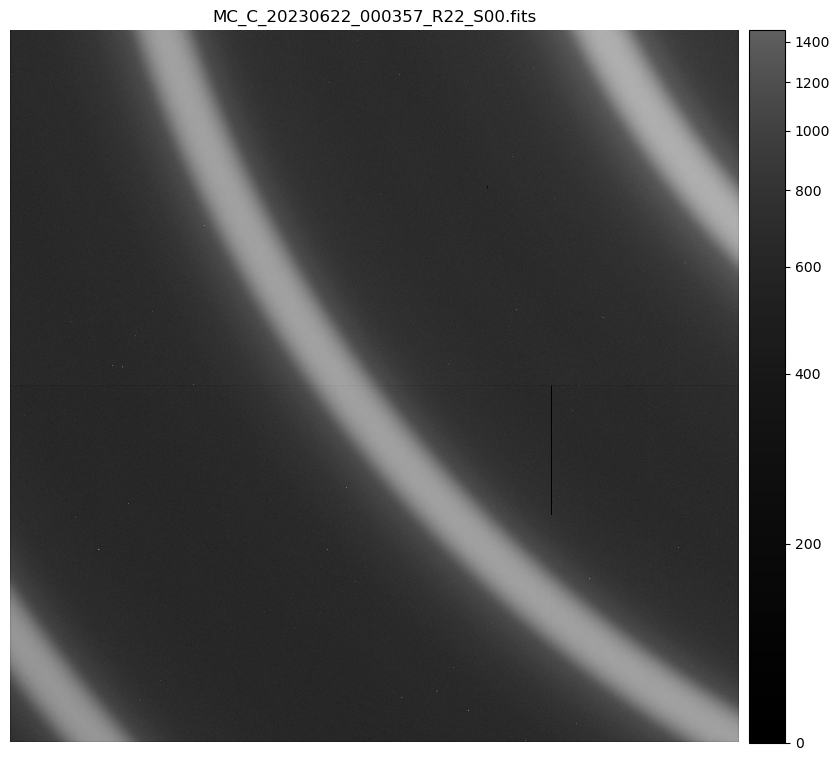

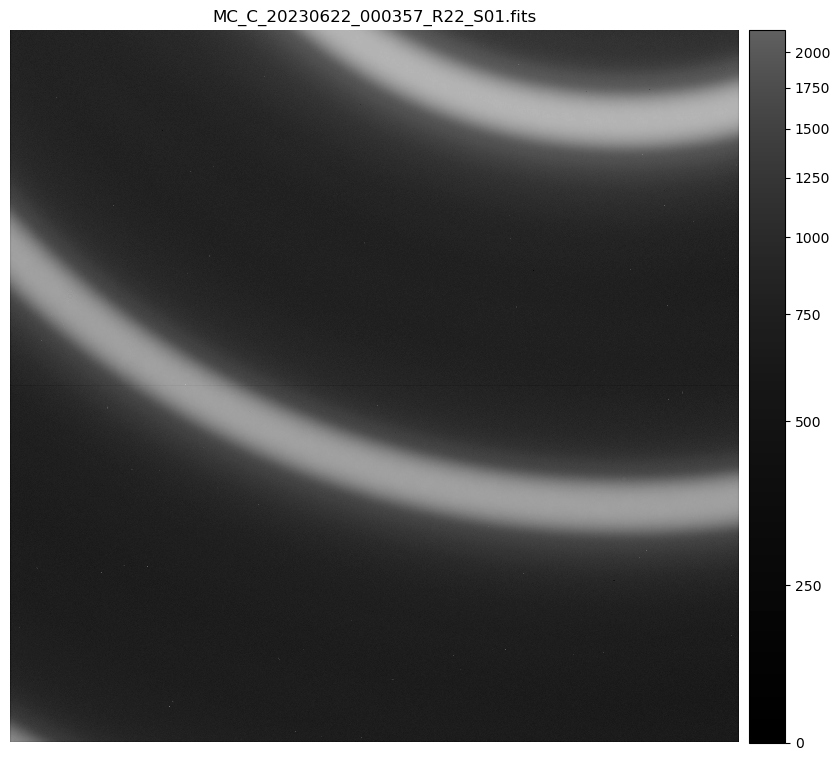

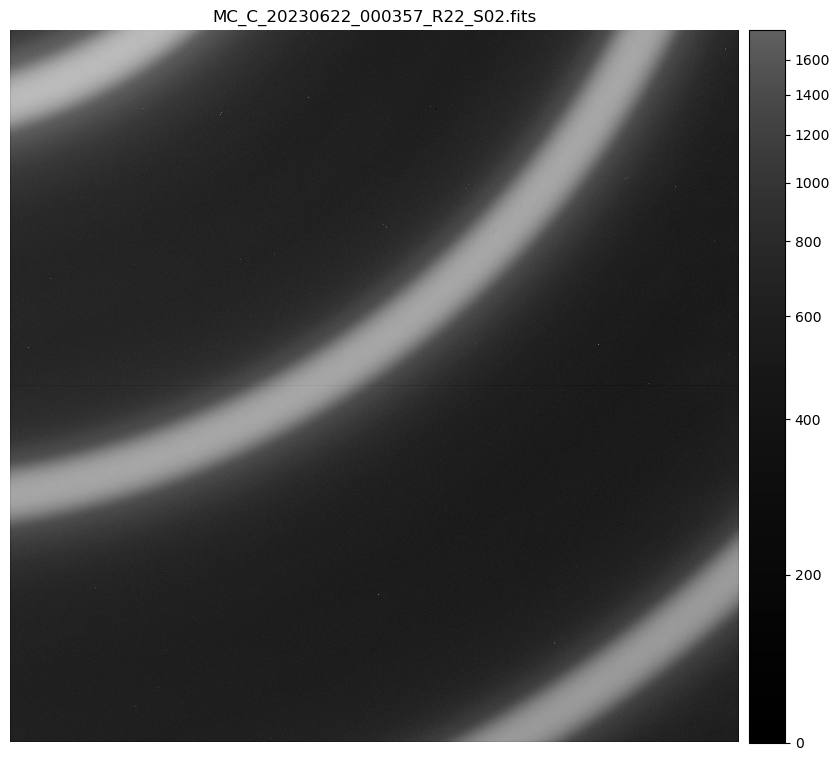

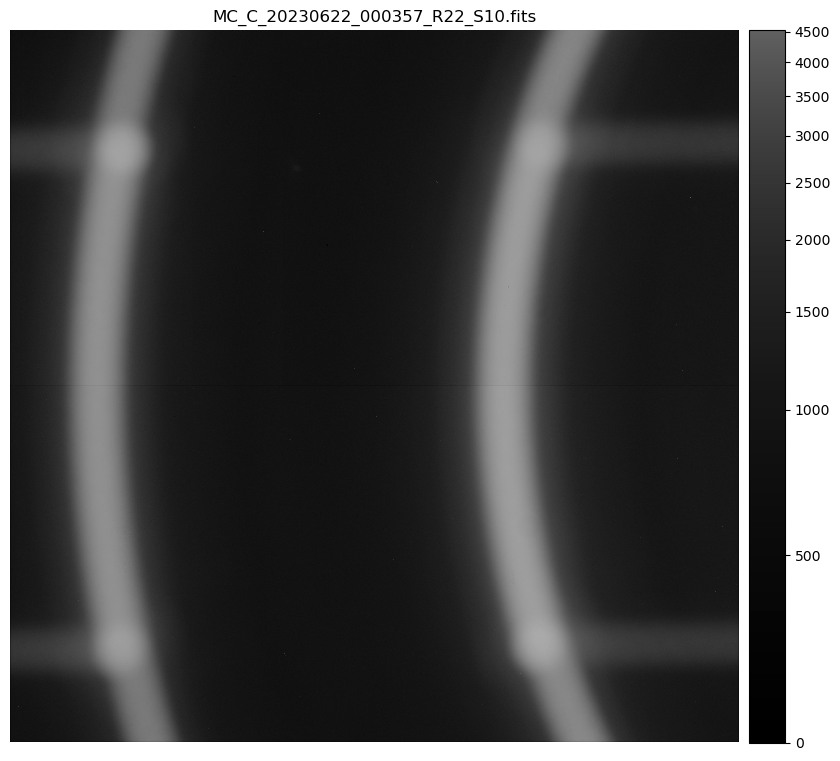

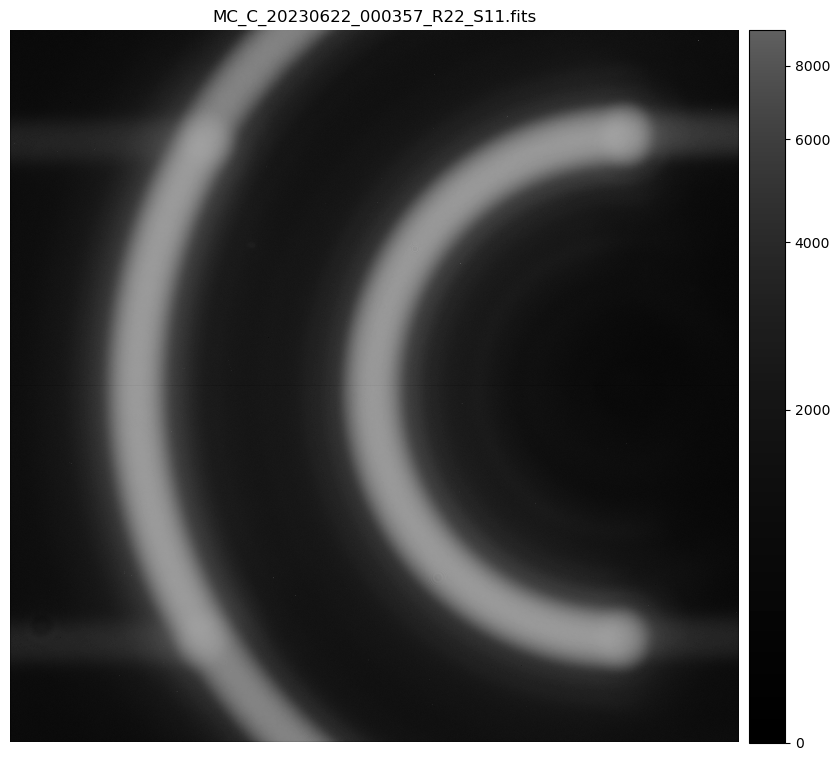

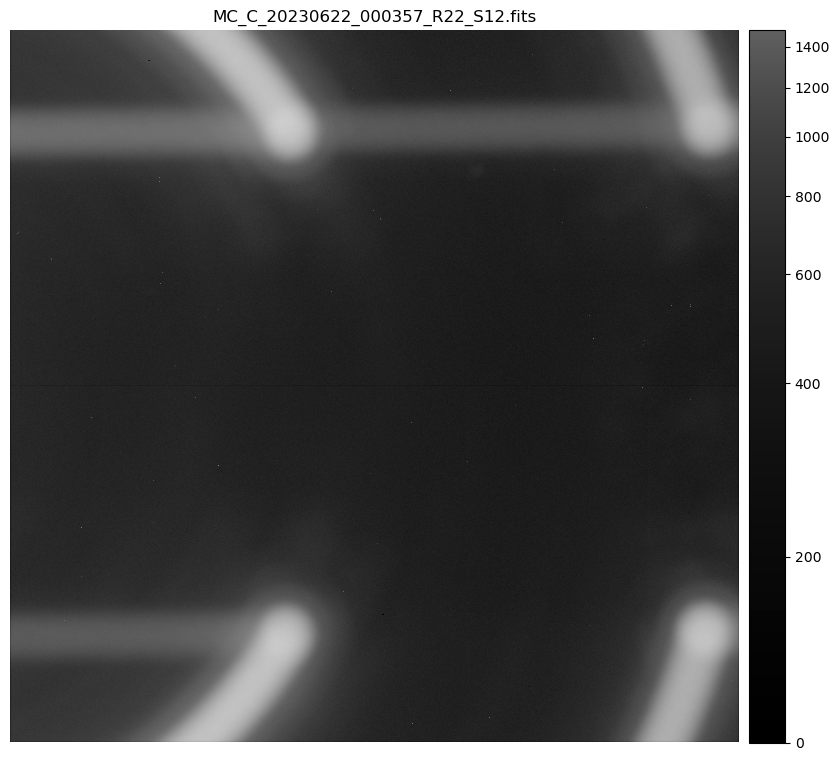

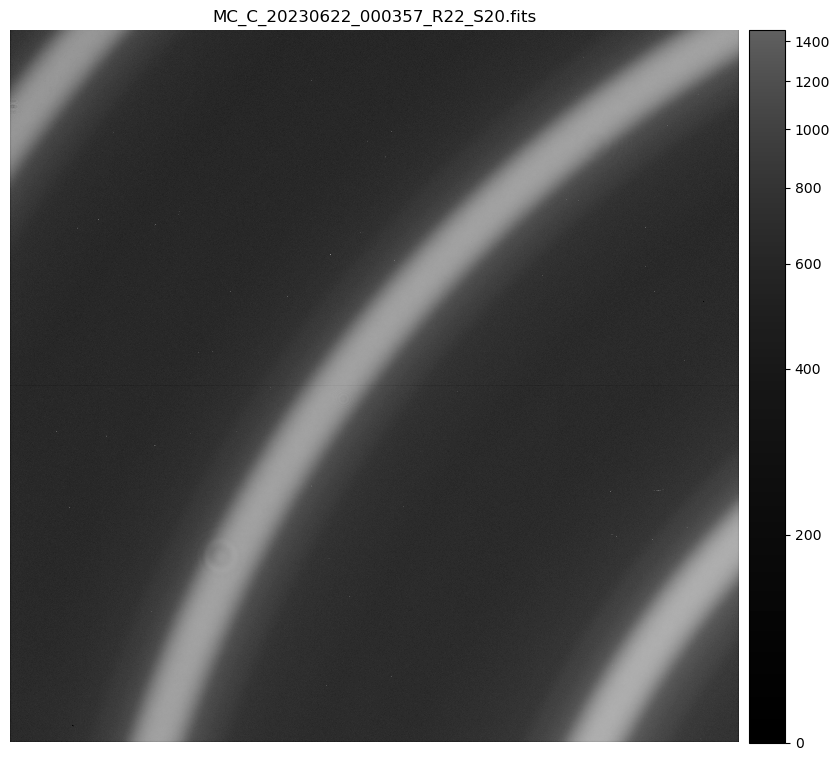

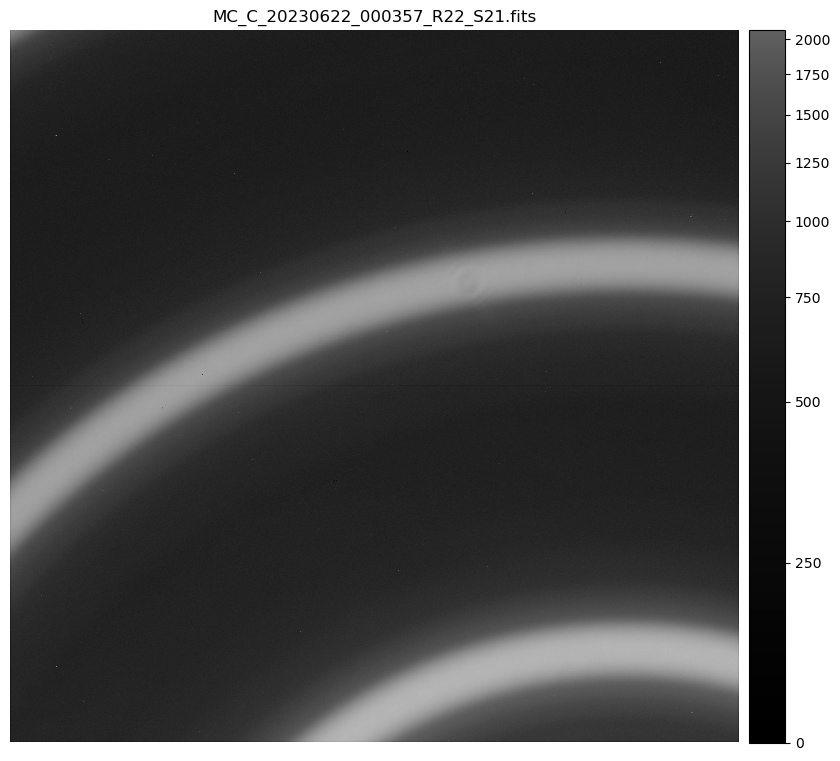

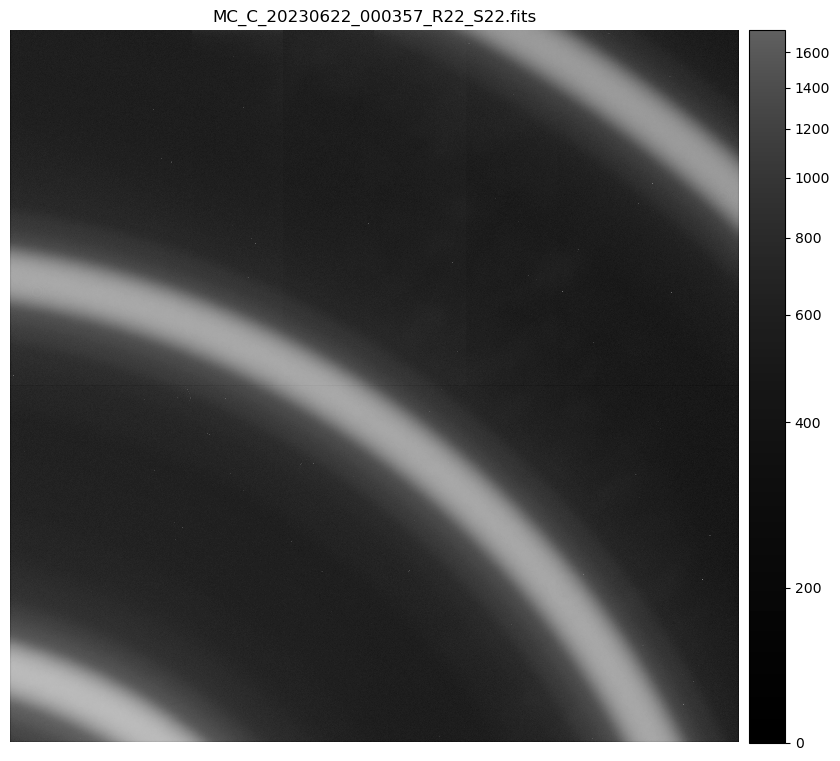

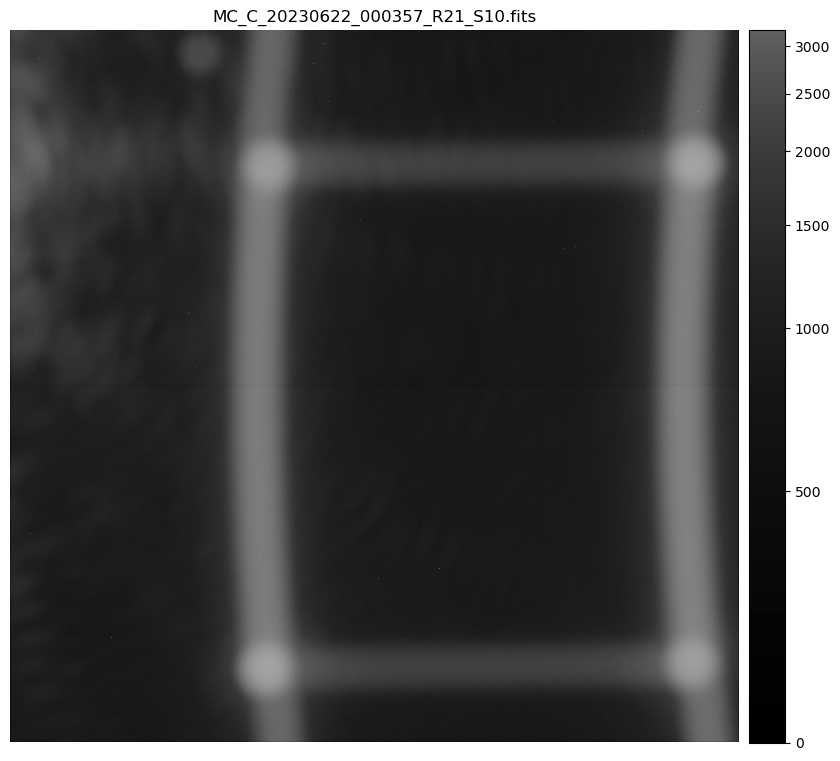

In [ ]:
my_detectors = ['R22_S00', 'R22_S01', 'R22_S02', 'R22_S10', 'R22_S11', 'R22_S12', 'R22_S20', 'R22_S21', 'R22_S22',
                'R21_S10', 'R21_S11', 'R21_S12', 'R32_S01', 'R32_S11', 'R32_S21'] 

mosaic = make_mosaic(butler, refs357, camera, 8, my_detectors)

In [ ]:
mar = mosaic.getArray()
mma= np.ma.filled(np.ma.masked_values(mar,0.0000),np.nan)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10.,10.))

im, norm = imshow_norm(mma, ax, origin='lower', interpolation='None',cmap='plasma',
                       stretch=LinearStretch())


In [ ]:
show_hv_slices(mma, 750, 2500, 'full')